<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/basic_lm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

     |████████████████████████████████| 46 kB 4.1 MB/s 


In [ ]:
import fastai
fastai.__version__

'2.7.7'

In [ ]:
# config depending on whether this is running on kaggle or collab
is_colab = True
comp = 'feedback-prize-effectiveness'
if is_colab:
    model_save_path = Path('/content/'+comp+'/models')
else:
    model_save_path = Path('/kaggle/working/'+comp+'/models')

In [ ]:
# import colab libraries
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
if is_colab:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [ ]:
# This permissions change avoids a warning on Kaggle tool startup.
if is_colab:
    !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
path = setup_comp(comp)
path

In [ ]:
from fastai.text.all import *
set_seed(32)

## Language model for original text

In [ ]:
dls_lm = TextDataLoaders.from_folder(path / 'train', is_lm=True, valid_pct=0.1)
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj dear xxmaj senator , \n\n xxmaj we should be changing to the election by popular vote for the president of the xxmaj united xxmaj states . xxmaj everyone should just vote for the vice president and the president . xxmaj people are voting for the xxmaj electoral college while they should be voting to see who will be their new president . xxmaj the electoral college is getting more votes","xxmaj dear xxmaj senator , \n\n xxmaj we should be changing to the election by popular vote for the president of the xxmaj united xxmaj states . xxmaj everyone should just vote for the vice president and the president . xxmaj people are voting for the xxmaj electoral college while they should be voting to see who will be their new president . xxmaj the electoral college is getting more votes than"
1,"staff that focus mostly on students learning the course material at their own pace . xxmaj take generic_school 's xxup vision program for example . xxup vision offers xxup xxunk as well as non - xxunk students many different courses from xxmaj english and math , to economics and personal finance . xxmaj if home schooled students could join some of these courses , there will definitely be many benefits for","that focus mostly on students learning the course material at their own pace . xxmaj take generic_school 's xxup vision program for example . xxup vision offers xxup xxunk as well as non - xxunk students many different courses from xxmaj english and math , to economics and personal finance . xxmaj if home schooled students could join some of these courses , there will definitely be many benefits for both"
2,sad or upset . xxmaj the computer can help a teacher / adult to understand when a student is in need of a talk or needs to express their emotions . xxmaj this is also very valuable because it could potentially save a life in bad situations . xxmaj the computer facial coding system is valuable in my opinion for various reasons as you may see in this essay . \n\n xxmaj,or upset . xxmaj the computer can help a teacher / adult to understand when a student is in need of a talk or needs to express their emotions . xxmaj this is also very valuable because it could potentially save a life in bad situations . xxmaj the computer facial coding system is valuable in my opinion for various reasons as you may see in this essay . \n\n xxmaj this
3,in car accidents from driving and texting . \n\n xxmaj my friends was in a accident because he was texting and driving . xxmaj its no joke he almost lost he life and his xxunk too . xxmaj texting and driving is awful . \n\n xxmaj so if you love your life and who you where with you wo n't text and drive . xxmaj in over 30 states its illegal to,car accidents from driving and texting . \n\n xxmaj my friends was in a accident because he was texting and driving . xxmaj its no joke he almost lost he life and his xxunk too . xxmaj texting and driving is awful . \n\n xxmaj so if you love your life and who you where with you wo n't text and drive . xxmaj in over 30 states its illegal to text
4,the article mentions that cameras might be needed to ensure people pay attention to the road . xxmaj there are already enough distractions for drivers to worry about . xxmaj texting and driving has become a major issue in recent years . xxmaj imagine how easy it would be to be distracted by a phone or other device if the car you were in were driving itself ? xxmaj this is a,article mentions that cameras might be needed to ensure people pay attention to the road . xxmaj there are already enough distractions for drivers to worry about . xxmaj texting and driving has become a major issue in recent years . xxmaj imagine how easy it would be to be distracted by a phone or other device if the car you were in were driving itself ? xxmaj this is a slippery


In [ ]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [ ]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.761075,3.434725,0.325304,31.022888,01:30


In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.536679,3.320854,0.342587,27.683989,01:34
1,3.405760,3.223232,0.360429,25.109131,01:34
2,3.278480,3.141706,0.373064,23.143316,01:34
3,3.175086,3.091677,0.379439,22.013969,01:34
4,3.061083,3.052163,0.387028,21.161070,01:34
5,2.982667,3.024457,0.391141,20.582819,01:34
6,2.930097,3.013953,0.393328,20.367764,01:34
7,2.893255,2.998582,0.395244,20.057074,01:34
8,2.828343,2.995264,0.395900,19.990633,01:34
9,2.803145,2.996284,0.395720,20.011032,01:45


In [ ]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn_lm.save_encoder(model_save_path / 'finetuned')

## Text classification

In [ ]:
# create data loaders
df = pd.read_csv(path/'train.csv')
dls = TextDataLoaders.from_df(df, text_col='discourse_text',
                              label_col='discourse_effectiveness',
                              text_vocab=dls_lm.vocab)
dls.show_batch(max_n=3)

,text,category
0,xxbos xxmaj you can search the website up so that you can finished it the assignment to handle it in to your teacher if you missing anything from your others class you can finished with your others class you have with your xxunk . xxmaj if you stuck on the question go asked your teacher to helped you out now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen show up and now go to the website that is on your paper to finished on your assignment on your homework . \n\n xxmaj first now go to any comptuer that you wanted to be in you have to sign in thorugh your computer to xxunk in now you hace to wait xxunk the screen is done . xxmaj now listen,Ineffective
1,"xxbos "" xxmaj attention students , participate in at least one extracurricular activity , "" said my principal . ' \n\n "" one of these days again ? "" "" i hate this school , we do this every week . "" generic_name why do you like doing this so much ? "" "" he s letting us play sports , work on the year book , and even have free talking time . "" generic_name said . xxmaj out of nowhere , \n\n "" generic_name and generic_name come here ! "" \n\n xxmaj me and generic_name looked at each other and said ' where in trouble ' xxmaj we went to xxmaj mr . generic_name xxmaj office and he asked \n\n "" are you boys going to do any activity 's ? ' xxmaj we were xxunk harder than ever . "" yes sir "" generic_name said ,",Ineffective
2,"xxbos xxmaj driveways , home garages , and street parking and forbidden in the experiment of the outskirts on the xxunk district . xxmaj in a place called xxmaj vauban 's streets are completly "" car - free "" . xxmaj the only places that are not car free are downtown near the tram . xxmaj you can only have two places to park and those two places are home , and large garages only at the edge of the developement it costs $ 40 , xxrep 3 0 . xxmaj fifty - seven percent sold a car to move here , and seventy percent of families do not own a car . xxmaj they say "" when i had a car i was always tense . xxmaj xxunk happier this way "" . xxmaj suburbs have linchpin called automobiles . xxmaj up to fifty percent in some car- intensive",Ineffective


In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1Score(average='weighted')]).to_fp16()

learn = learn.load_encoder(model_save_path / 'finetuned')

SuggestedLRs(valley=0.002511886414140463, slide=0.019054606556892395)

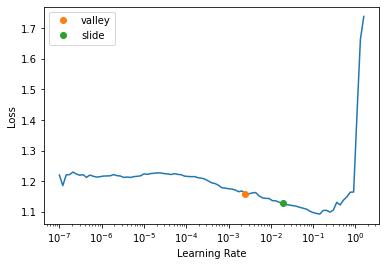

In [ ]:
learn.lr_find(suggest_funcs=(valley, slide))

In [ ]:
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.847548,0.834096,0.603019,0.579364,00:50


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.783406,0.783160,0.647083,0.604745,01:05
1,0.767481,0.759484,0.665851,0.634594,01:05
2,0.688172,0.756510,0.671155,0.651379,01:05
3,0.573077,0.820240,0.671155,0.652837,01:05
4,0.497917,0.847670,0.664219,0.651794,01:05


In [ ]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn.export(f'{model_save_path}/basic_lm_text_learner.pkl')

## Test submission

In [ ]:
test_df = pd.read_csv(path/'test.csv')
test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   discourse_id    10 non-null     object
 1   essay_id        10 non-null     object
 2   text            10 non-null     object
 3   discourse_type  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


In [ ]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxmaj taking other peoples advice and doing what they say may lead to a great outcome . xxmaj when you receive other opinions whether they are good or bad you will be able to look at them from a different point of view . xxmaj for example , xxmaj when a group of people give you advice on yourself , you then know how they look at you as a person . xxmaj everyone looks at certain things from a different xxunk . xxmaj how someone else looks at it may be how its supposed to be viewed in life ."
1,"xxbos xxmaj everyone is different and may have more experience than you . xxmaj seeking other peoples opinion can cause you to gain a new skill or lesson . xxmaj for example , someones advice could teach you how to do something the correct way . xxmaj many people are very different and have experience different things in life . xxmaj seeking advice from others can teach you a lot . xxmaj we all learn from our mistakes in life , by sharing your past experiences you may prevent someone else from making the same mistake ."
2,xxbos xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice .
3,xxbos xxmaj you can learn from others experiences by seeking the advice that someone give you . xxmaj making decisions can cause stress on a person . xxmaj relating to someones advice may higher your self - esteem because you no longer feel left out . xxmaj ask others for advice when making a difficult decision . xxmaj when you seek others opinion more opportunities are available fro yourself .
4,xxbos xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself .
5,xxbos xxmaj seeking multiple opinions can help a person make a better choice
6,xxbos xxmaj seeking others opinion can be very helpful and beneficial .
7,xxbos a great chance to learn something new
8,xxbos can be very helpful and beneficial .


In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[3.2493e-01, 6.7294e-01, 2.1293e-03],
        [8.6966e-01, 6.6345e-02, 6.3990e-02],
        [9.3367e-02, 1.0353e-02, 8.9628e-01],
        [5.4736e-01, 8.2296e-02, 3.7035e-01],
        [9.3367e-02, 1.0353e-02, 8.9628e-01],
        [3.1832e-01, 6.8016e-01, 1.5276e-03],
        [1.6392e-01, 8.3489e-01, 1.1931e-03],
        [5.9668e-01, 1.7137e-01, 2.3196e-01],
        [6.3365e-01, 3.6566e-01, 6.9155e-04],
        [2.6672e-01, 7.3249e-01, 7.9708e-04]])

In [ ]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = dls.vocab[1])
probs_df

,Adequate,Effective,Ineffective
0,0.324934,0.672936,0.002129
1,0.869665,0.066345,0.063990
2,0.093367,0.010353,0.896280
3,0.547356,0.082296,0.370348
4,0.093367,0.010353,0.896280
5,0.318316,0.680156,0.001528
6,0.163918,0.834889,0.001193
7,0.596675,0.171368,0.231956
8,0.633652,0.365657,0.000692
9,0.266717,0.732486,0.000797


In [ ]:
probs_df["discourse_id"] = test_df["discourse_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

Adequate,Effective,Ineffective,discourse_id
0.32493442,0.6729363,0.0021292958,a261b6e14276
0.86966485,0.06634482,0.06399039,5a88900e7dc1
0.093366645,0.010353404,0.89628,9790d835736b
0.5473558,0.082296096,0.37034816,75ce6d68b67b
0.093366645,0.010353404,0.89628,93578d946723
0.31831622,0.6801563,0.0015275878,2e214524dbe3
0.16391838,0.8348886,0.0011930547,84812fc2ab9f
0.59667546,0.17136826,0.23195633,c668ff840720
0.6336518,0.36565667,0.00069155474,739a6d00f44a


In [ ]:
# not working for this competetion
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial', comp)

In [ ]:
if not iskaggle:
    push_notebook('saan', comp,
                  title='Feedback effeciveness  initial model',
                  file='/content/drive/MyDrive/Colab Notebooks/basic_lm_model.ipynb',
                  competition=comp, private=True, gpu=True)